# **Agents Estimation and AQI prediction**

After finding the best model for each agent, use them to compute the complessive pollution estimatins and compute AQI values.

In [2]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Models
import tensorflow as tf
from sklearn.ensemble import RandomForestRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import xgboost as xgb

from utils import *

datasets_folder = './datasets'
verbosity = 0
figsize = (18,4)

tf.config.set_visible_devices([], 'GPU')
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Notebook Setup

In [3]:
pollution_data = read_and_preprocess_dataset(datasets_folder, 'pollution', v=verbosity)
traffic_data = read_and_preprocess_dataset(datasets_folder, 'traffic', v=verbosity)
weather_data = read_and_preprocess_dataset(datasets_folder, 'weather', v=verbosity)

stations = pollution_data.keys()

In [4]:
station_data = {}
date_encoding = 'radial_months-sin-cos_days_hours'

for station in stations:
    station_data[station] = prepare_station_data_for_training(
        pollution_data[station], 
        traffic_data[station], 
        weather_data, 
        encoding_method=date_encoding,
        # weather merging parameters:
        aggregations = DEFAULT_AGGREGATIONS,
        max_min_columns = DEFAULT_MAX_MIN_COLUMNS, 
        # traffic merging parameters:
        bin_size = 8,
        offset = 2
    )
    
    print(f'Station {station} agents: ',', '.join(list(station_data[station].keys())))

n_hour_features = len(station_data['GIARDINI MARGHERITA']['NO2'].columns) - 1 # -1 because Agent_value is the target
n_daily_features = len(station_data['GIARDINI MARGHERITA']['PM2.5'].columns) - 1 # -1 because Agent_value is the target

Station GIARDINI MARGHERITA agents:  NO2, O3, PM10, PM2.5
Station PORTA SAN FELICE agents:  C6H6, CO, NO2, PM10, PM2.5
Station VIA CHIARINI agents:  NO2, O3, PM10


In [5]:
train_split_date = datetime(2023,12,31,23)
target = 'Agent_value'

In [6]:
training_sets = {}
test_sets = {}

for station in stations:
    training_sets[station] = {}
    test_sets[station] = {}
    for agent in station_data[station].keys():
        training_sets[station][agent] = {}
        test_sets[station][agent] = {}

        x_train, y_train, x_test, y_test = create_train_test(station_data[station][agent], train_split_date, y=target)

        training_sets[station][agent]['x'] = x_train
        training_sets[station][agent]['y'] = y_train
        test_sets[station][agent]['x'] = x_test
        test_sets[station][agent]['y'] = y_test

## Agents Estimations

Prepare a dictionary containing the model to use for each agent of each station

In [17]:
def buid_lstm_model(time_steps, n_features, optimizer='adam', loss='mean_absolute_error'):
    model = Sequential([
        LSTM(128, return_sequences=False, input_shape=(time_steps, n_features)),
        # Dropout(0.2),
        # LSTM(50, return_sequences=False),
        # Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=optimizer, loss=loss)

    return model

lstm_params = {
    'time_steps': 3,
    'n_features': n_hour_features,
    'optimizer': Adam(learning_rate=1e-3),
    'loss': 'mean_absolute_error'
}
lstm_params2 = {
    'time_steps': 1,
    'n_features': n_daily_features,
    'optimizer': Adam(learning_rate=1e-3),
    'loss': 'mean_absolute_error'
}

lstm_train_params = {
    'epochs':20,
    'batch_size':64,
}

test = ('LSTM', buid_lstm_model, lstm_params, lstm_train_params, True)
test2 = ('LSTM', buid_lstm_model, lstm_params2, lstm_train_params, True)
models = {
    'GIARDINI MARGHERITA':{
        'NO2':test, 
        'O3':test, 
        'PM10':test2,
        'PM2.5':test2 
    },
    'PORTA SAN FELICE':{
        'C6H6':test, 
        'CO':test, 
        'NO2':test, 
        'PM10':test2,  
        'PM2.5':test2 
    },
    'VIA CHIARINI':{
        'NO2':test, 
        'O3':test, 
        'PM10':test2  
    }
}

In [18]:
agents_predictions = train_agents(models, training_sets, test_sets)

Predicting NO2 in GIARDINI MARGHERITA using LSTM...
Predicting O3 in GIARDINI MARGHERITA using LSTM...
Predicting PM10 in GIARDINI MARGHERITA using LSTM...
Predicting PM2.5 in GIARDINI MARGHERITA using LSTM...
Predicting C6H6 in PORTA SAN FELICE using LSTM...
Predicting CO in PORTA SAN FELICE using LSTM...
Predicting NO2 in PORTA SAN FELICE using LSTM...
Predicting PM10 in PORTA SAN FELICE using LSTM...
Predicting PM2.5 in PORTA SAN FELICE using LSTM...
Predicting NO2 in VIA CHIARINI using LSTM...
Predicting O3 in VIA CHIARINI using LSTM...
Predicting PM10 in VIA CHIARINI using LSTM...


## AQI calculation

In [19]:
pred_AQIs_daily = {
    s: {agent: get_AQI(agents_predictions[s][agent], 
                        agent=agent, 
                        period='day', 
                        value_column='Agent_value',
                        breakpoints=True
                        ) for agent in agents_predictions[s].keys()} for s in agents_predictions
}
pred_AQIs_hourly = {
    s: {agent: get_AQI(agents_predictions[s][agent],
                       agent=agent,
                       period='hour', 
                       value_column='Agent_value',
                       breakpoints=False,
                       include_hourly_pm=False
                       ) for agent in agents_predictions[s].keys()} for s in agents_predictions
}

In [20]:
true_AQIs_daily = {
    s: {agent: get_AQI(test_sets[s][agent]['y'], 
                        agent=agent, 
                        period='day', 
                        value_column='Agent_value',
                        breakpoints=True
                        ) for agent in test_sets[s].keys()} for s in test_sets
}
true_AQIs_hourly = {
    s: {agent: get_AQI(test_sets[s][agent]['y'],
                       agent=agent,
                       period='hour', 
                       value_column='Agent_value',
                       breakpoints=False,
                       include_hourly_pm=False
                       ) for agent in test_sets[s].keys()} for s in test_sets
}

## AQI Comparison

se sei in grado abbelliscilo pure

Station GIARDINI MARGHERITA AQI:


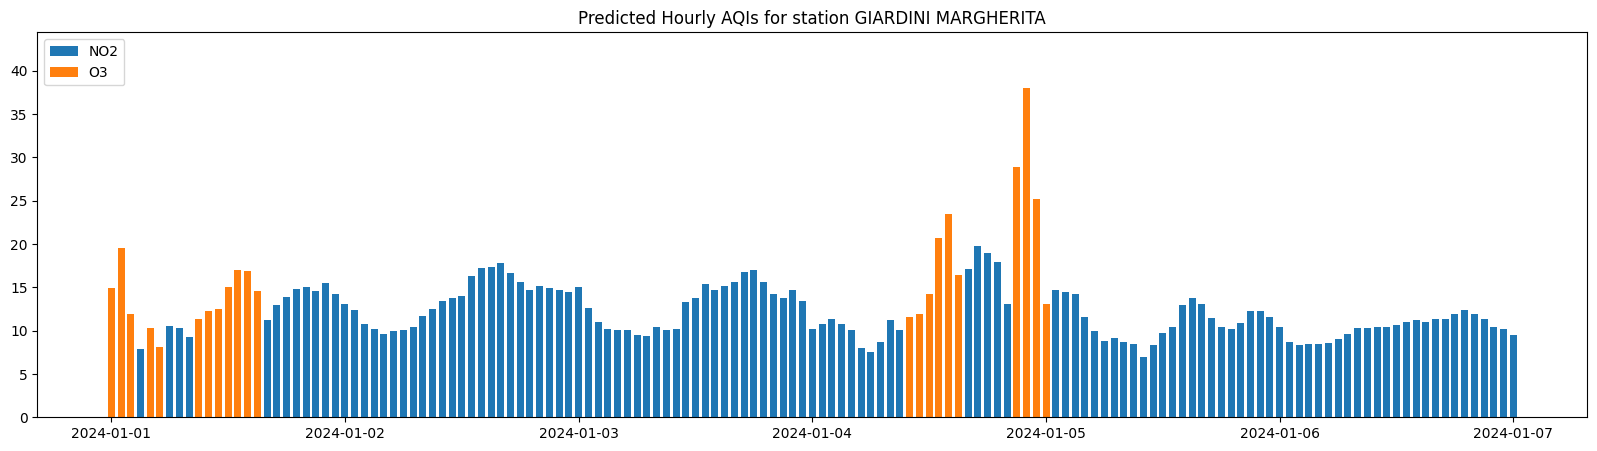

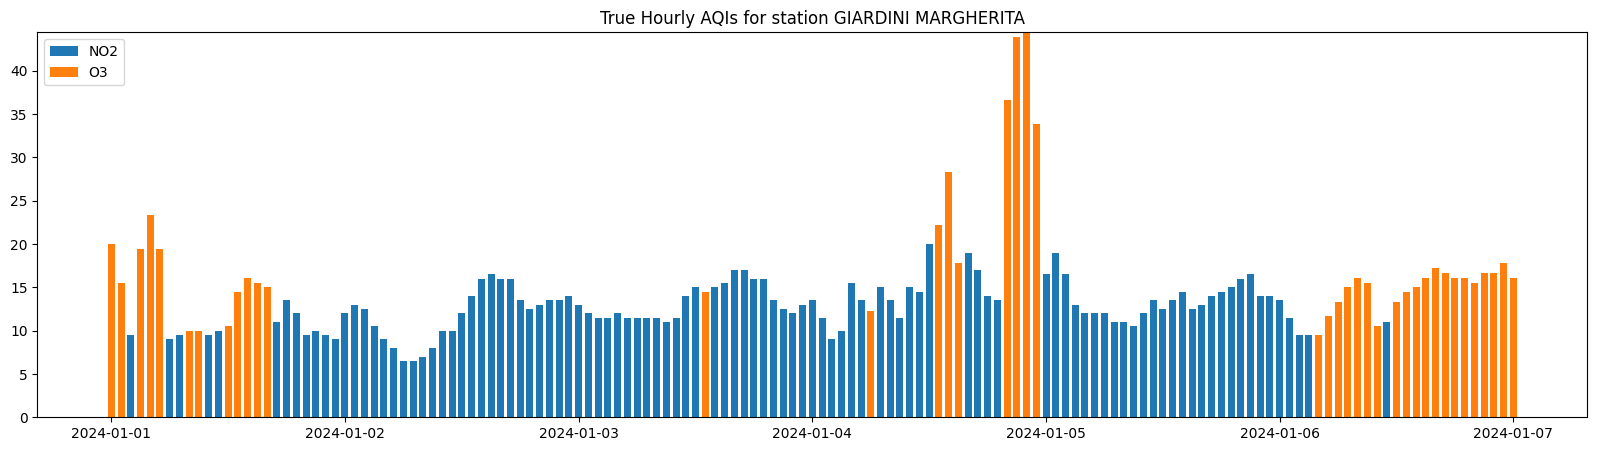

Station PORTA SAN FELICE AQI:


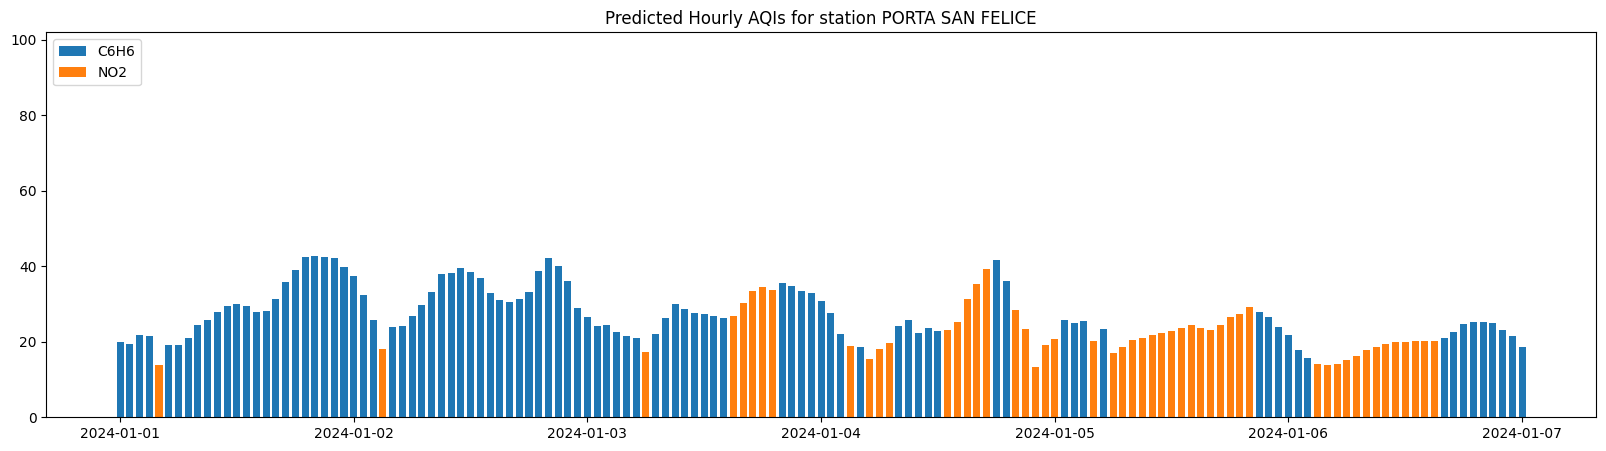

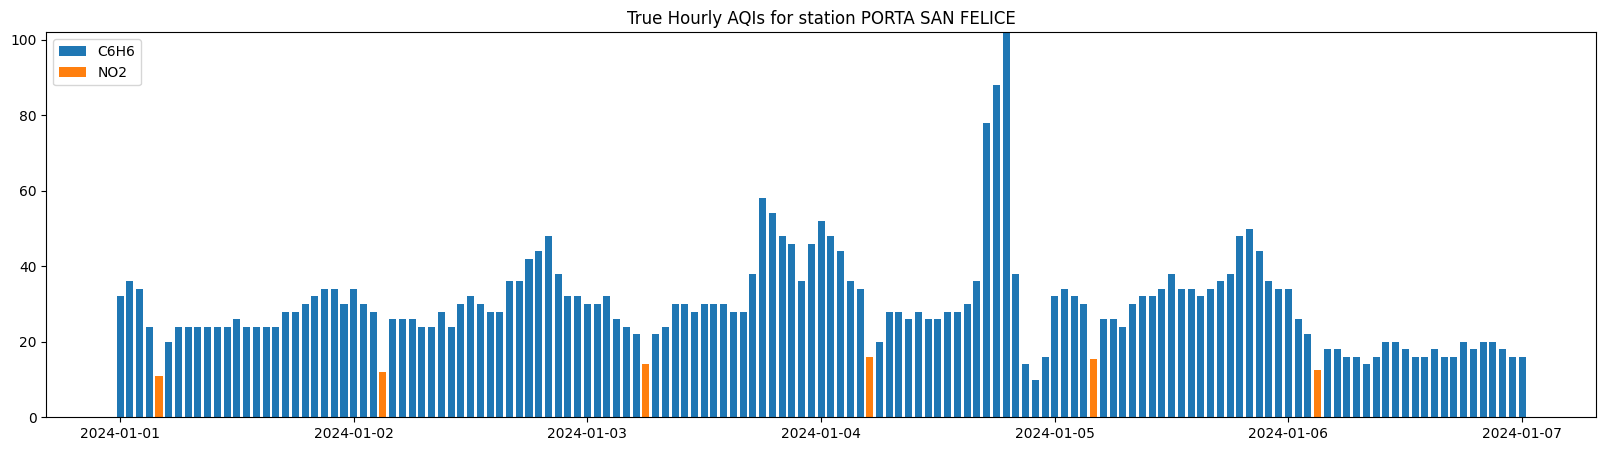

Station VIA CHIARINI AQI:


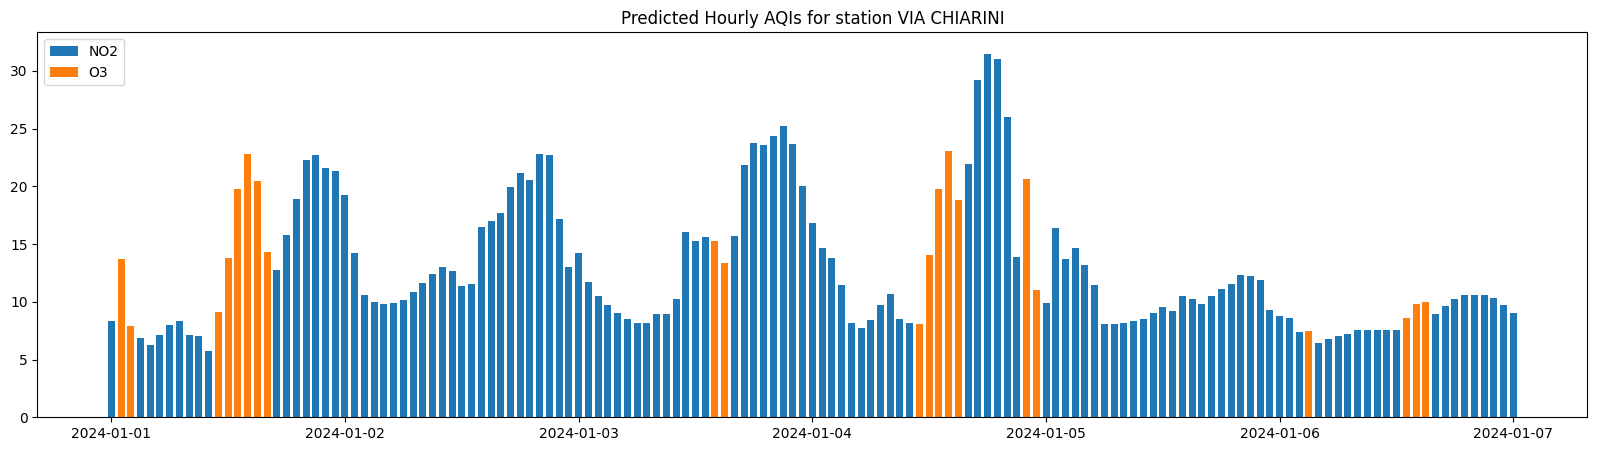

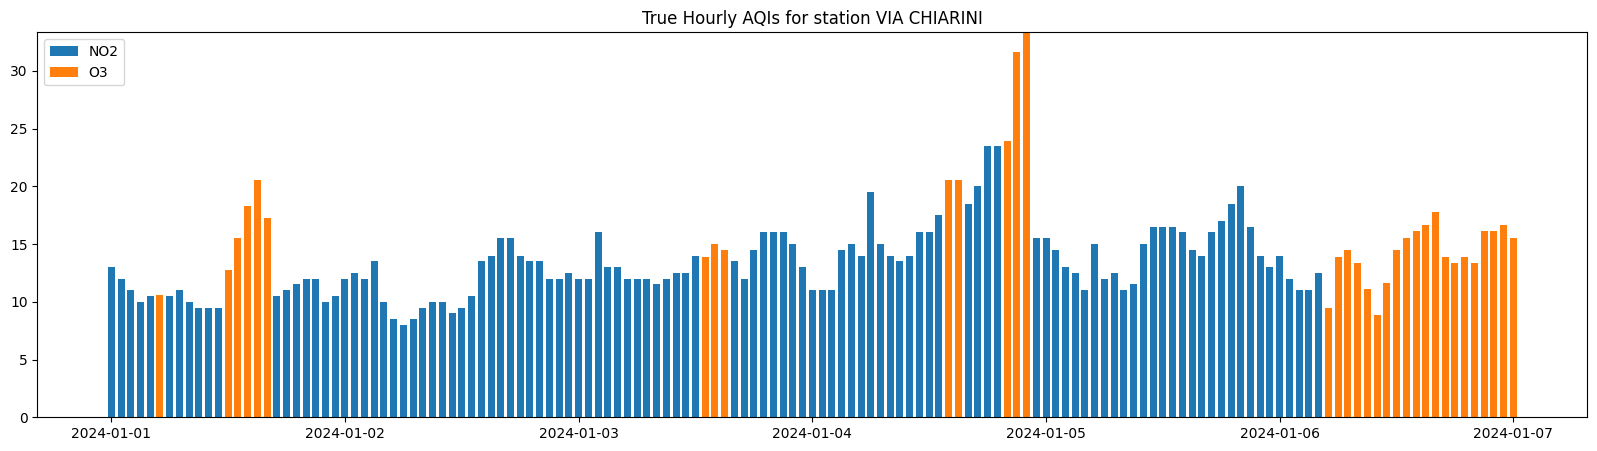

In [21]:
start=datetime(2024,1,1)
end=datetime(2024,1,7)

for station in true_AQIs_hourly:
    print(f'Station {station} AQI:')
    pred_ymax, true_ymax = 0,0
    for agent in true_AQIs_hourly[station].values():
        if len(agent)>0:
            tmp = max(agent['AQI'][(agent['AQI'].index>=start)&(agent['AQI'].index<=end)])
            if tmp>true_ymax:
                true_ymax = tmp
    for agent in pred_AQIs_hourly[station].values():
        if len(agent)>0:
            tmp = max(agent['AQI'][(agent['AQI'].index>=start)&(agent['AQI'].index<=end)])
            if tmp>pred_ymax:
                pred_ymax = tmp
    ylims = [0, max(pred_ymax, true_ymax)]

    plot_AQI(pred_AQIs_hourly[station], period='hour',title=f'Predicted Hourly AQIs for station {station}', figsize=(20, 5), s=start,e=end,ylims=ylims)
    plot_AQI(true_AQIs_hourly[station], period='hour',title=f'True Hourly AQIs for station {station}', figsize=(20, 5), s=start,e=end,ylims=ylims)

Station GIARDINI MARGHERITA AQI:


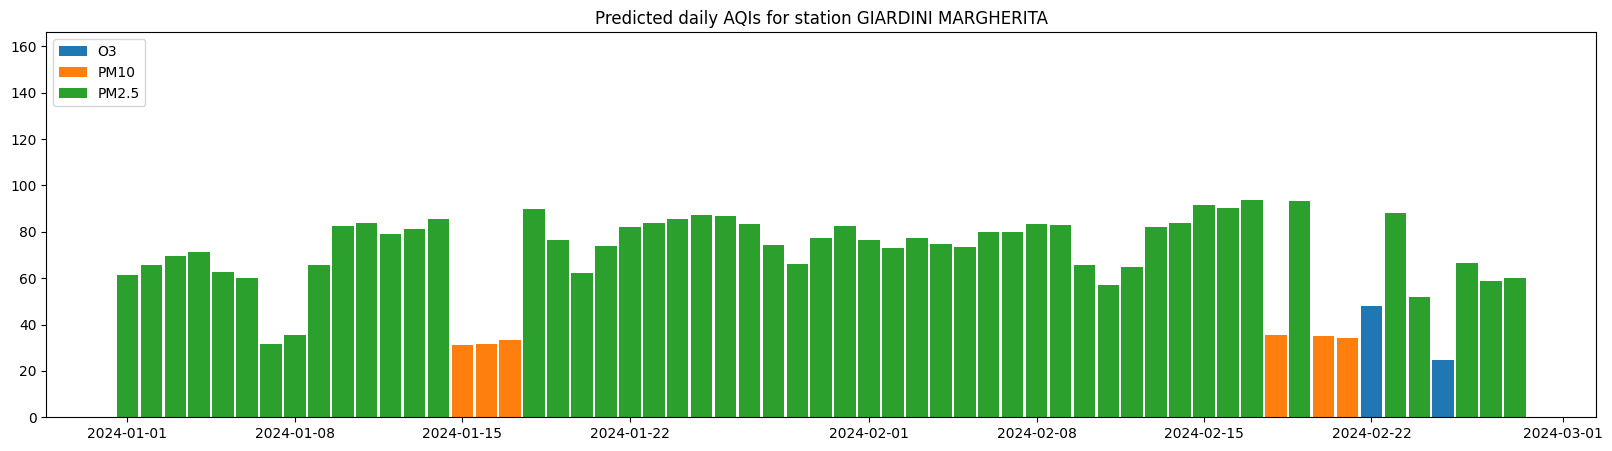

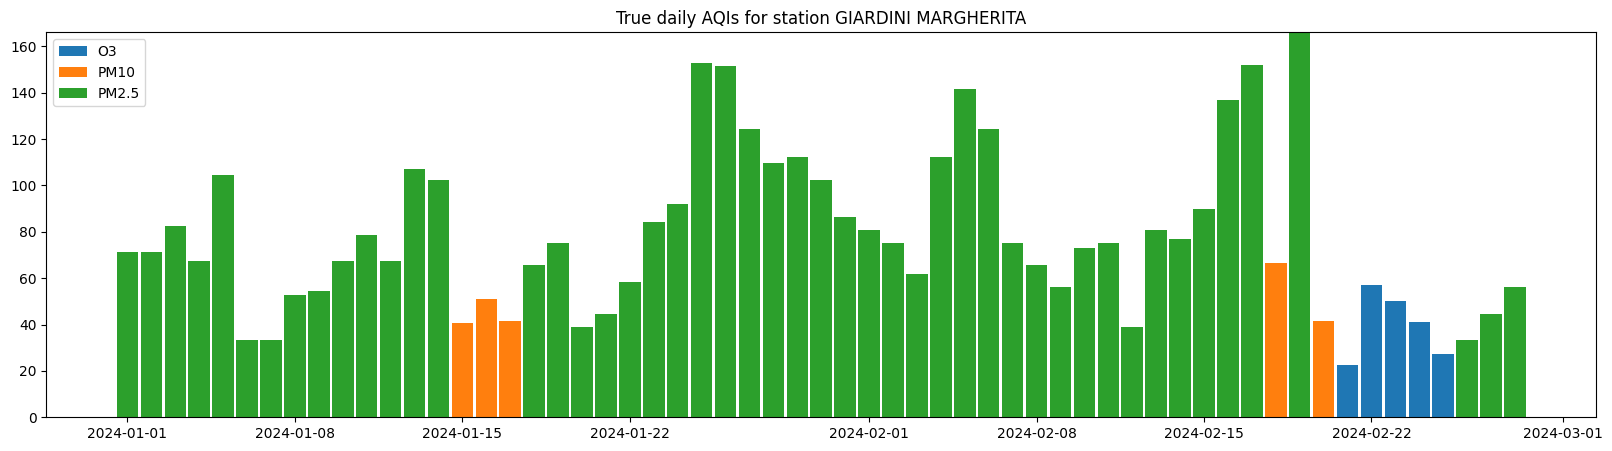

Station PORTA SAN FELICE AQI:


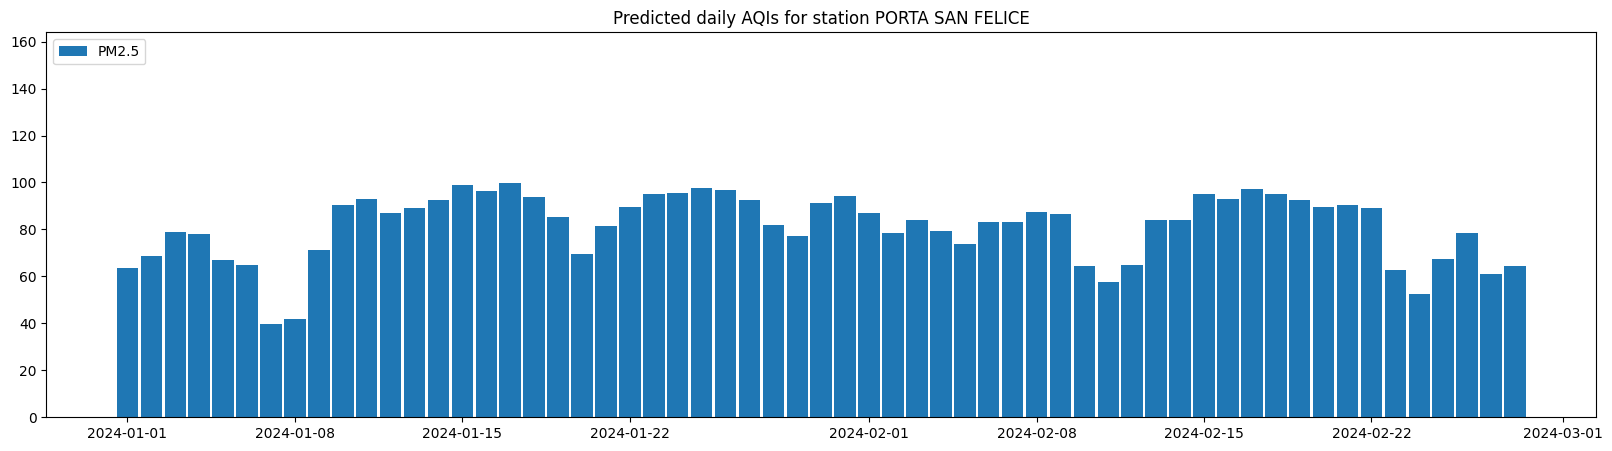

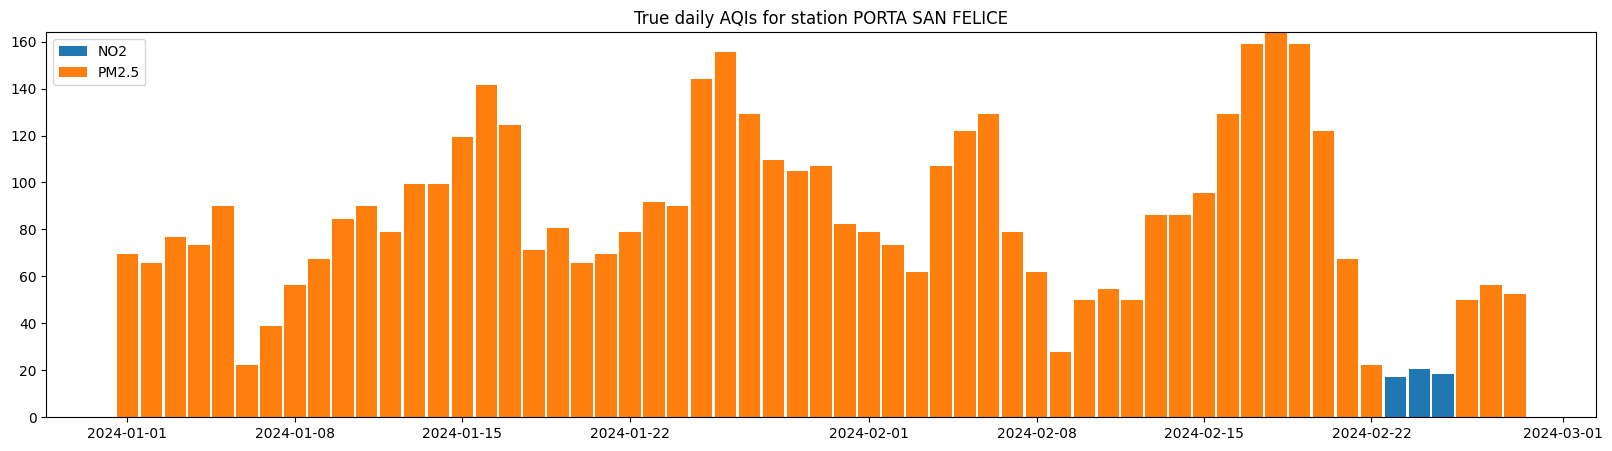

Station VIA CHIARINI AQI:


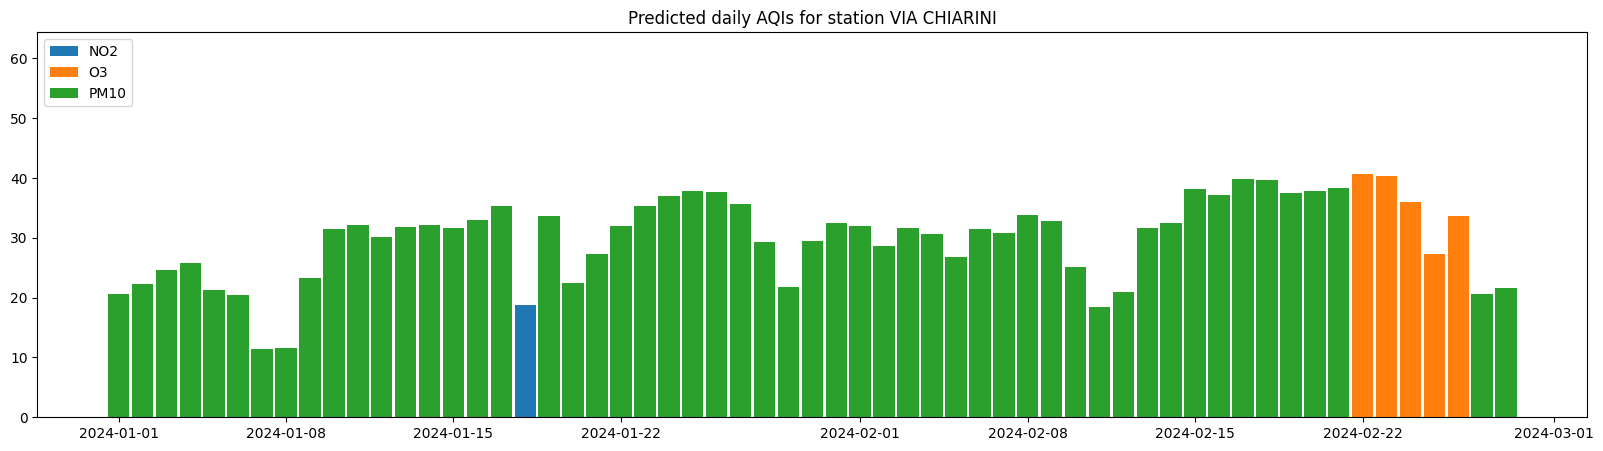

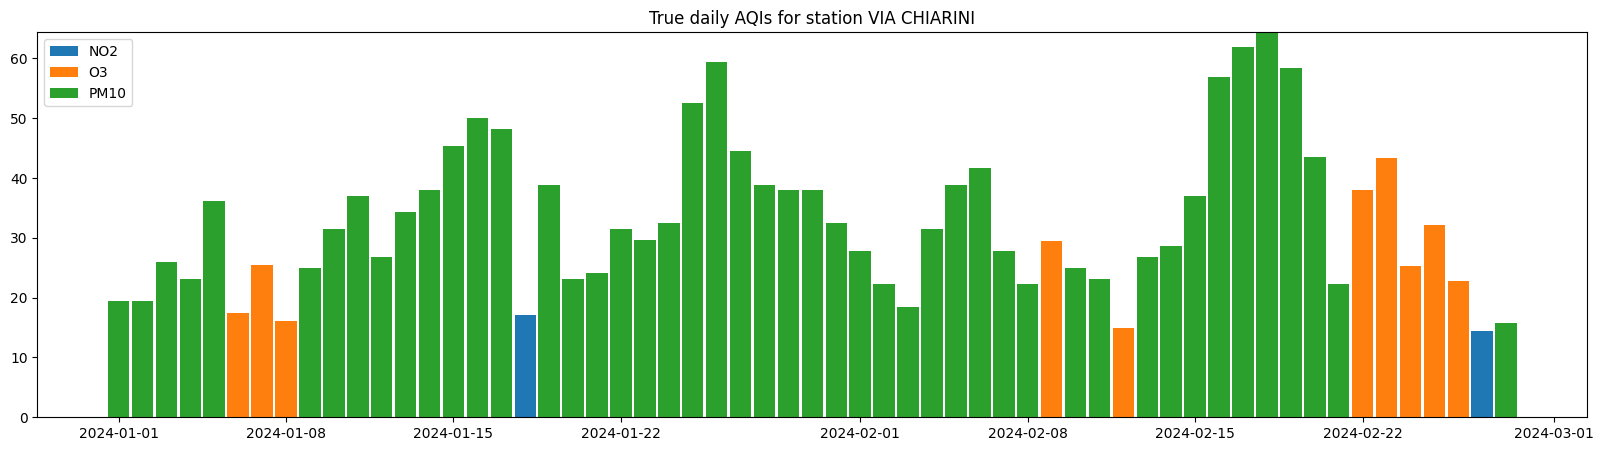

In [22]:
start=datetime(2024,1,1)
end=datetime(2024,2,28)

for station in true_AQIs_daily:
    print(f'Station {station} AQI:')
    pred_ymax, true_ymax = 0,0
    for agent in true_AQIs_daily[station].values():
        if len(agent)>0:
            tmp = max(agent['AQI'][(agent['AQI'].index>=start)&(agent['AQI'].index<=end)])
            if tmp>true_ymax:
                true_ymax = tmp
    for agent in pred_AQIs_daily[station].values():
        if len(agent)>0:
            tmp = max(agent['AQI'][(agent['AQI'].index>=start)&(agent['AQI'].index<=end)])
            if tmp>pred_ymax:
                pred_ymax = tmp
    ylims = [0, max(pred_ymax, true_ymax)]

    plot_AQI(pred_AQIs_daily[station], period='day',title=f'Predicted daily AQIs for station {station}', figsize=(20, 5), s=start,e=end,ylims=ylims)
    plot_AQI(true_AQIs_daily[station], period='day',title=f'True daily AQIs for station {station}', figsize=(20, 5), s=start,e=end,ylims=ylims)